## Monte Carlo Exploring Starts,the follwing graphs are ran for 10,000 episodes, report contains graphs for 50,000 episodes

In [1]:
#%%
import numpy as np
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#%%model initialisations
class BlackJack():
    def __init__(self):
        self.action_player = {}
        self.action_dealer = {}
        self.state_value = {}
        #total number of states 200
        self.states = list(itertools.product((np.arange(12,22)),\
                                             (np.arange(2,12)),
                                             (0,1),repeat = 1))
        self.sa_value = {}
        #self.sa_pair = {}
    
        
        #initialising random values to each state value
        for i in range(len(self.states)):
            self.state_value[self.states[i]] = np.random.random(1)
        
        #policy for player
        for i in range(len(self.states)):
            temp = self.states[i]
            if temp[0] >= 20:
                self.action_player[self.states[i]] = 'stick'
            else:
                self.action_player[self.states[i]] = 'hit'
                
        #policy for dealer
        for i in range(len(self.states)):
            temp_dealer = self.states[i]
            if temp_dealer[0] > 17:
                self.action_dealer[self.states[i]] = 'hit'
            else:
                self.action_dealer[self.states[i]] = 'stick'
                
        #giving random values to each state action pair
        action_space = ['hit','stick']
        for i in range(len(self.states)):
            for j in range(len(action_space)):
                self.sa_value[self.states[i],action_space[j]] = np.random.random(1)
                
#%%function for winning or losing for player and dealer
def win_lose_draw(player_sum,dealer_sum):
    loop_status = False
    #in case of draw, natural for both
    if  player_sum == dealer_sum ==21:  
        ret = 0
        loop_status = False
    #player wins
    elif (player_sum == 21) and (dealer_sum > 21 or dealer_sum < 21):
        ret = 1
        loop_status = False
    #player loses
    elif(player_sum > 21) and (dealer_sum <=21):
        ret = -1
        loop_status = False
    #player wins with dealers' sum > 21
    elif(player_sum <=21) and (dealer_sum > 21):
        ret = 1
        loop_status = False
    #dealer wins, gets natural
    elif(player_sum < 21 or player_sum > 21) and (dealer_sum == 21):
        ret = -1
        loop_status = False
    # game ends in a draw with both their sum>21
    else:
        loop_status = True
        ret = False
    return ret, loop_status

In [3]:
#%%start the episodes now
    
#initialise the object
bj = BlackJack()

#return at end of each episode
Return = {}

#card choices
card_ch = {}
card_ch['A'] = 'A'
for i in range(2,11):
    card_ch[str(i)] = i
#face cards
card_ch['K'] = 10
card_ch['Q'] = 10
card_ch['J'] = 10

#total number of episodes
episodes = 500000

ret_states = {}
ret_states_a = {}
state_iter = list(itertools.product((np.arange(12,22)),\
                                    (np.arange(2,12)),\
                                    (0,1),repeat = 1))

#defining the action space
action_space = ['hit','stick']
for i in range(len(state_iter)):
    for j in range(len(action_space)):
        ret_states_a[state_iter[i],action_space[j]] = []
        

#value returns for each states, Returns(S)
for i in range(len(state_iter)):
    ret_states[state_iter[i]] = []

#discounting factor    
gamma = 1

#probability of choosing an action
eps = 0.1

#start the episodes
for k_epi in range(episodes):
    
    reward_episode = []
    #array for appending states
    state_episode = []
    #state action pair
    sa_pair = []
    
    #card choices for players and dealers
    card_choice_player = []
    card_choice_dealer = []
    
    #Usable ace/not-boolean variable
    ace_u = 0
    
    #boolean variable loop to see to terminate the game
    loop_exit = False
    
    #start the game with two cards for player and dealer
    for i in range(1,2):
        card_choice = card_ch[np.random.choice(list(card_ch.keys()))]
        
      #check for the usability of Ace for player  
        if card_choice == 'A' and i == 1:
            card_choice = 11
        elif card_choice == 'A':
            if card_choice_player[0] == 11:
                card_choice = 1
                ace_u = 0
            else:
                card_choice = 11
                ace_u = 1
        card_choice_player.append(card_choice)
        
        # card for dealer
        card_choice = card_ch[np.random.choice(list(card_ch.keys()))]
        
        if card_choice == 'A':
            card_choice = 11
        card_choice_dealer.append(card_choice)
        
    player_sum = np.sum(card_choice_player)
    dealer_sum = card_choice_dealer[0]
    
    #start the game
    play_pd = True
    act_p = 'hit'
    loop = True
    loop_ret = True
    
    while loop == True:
        #case where player sum < 12
        if player_sum < 12:
            #start hitting for player
            card_choice = card_ch[np.random.choice(list(card_ch.keys()))]
            
            if card_choice == 'A' and (player_sum+11 <= 21):
                card_choice = 11
                ace_u = 1
            elif card_choice == 'A':
                card_choice = 1
                ace_u = 0
            card_choice_player.append(card_choice)
            player_sum = np.sum(card_choice_player)
            
            #check for player sum
            if player_sum == 21:
                card_choice = card_ch[np.random.choice(list(card_ch.keys()))]
                if card_choice == 'A':
                    card_choice = 11
                card_choice_dealer.append(card_choice)
                dealer_sum = np.sum(card_choice_dealer)
                
            #player wins with sum 21
                [ret, loop_ret ] = win_lose_draw(player_sum,dealer_sum)
             
            #player sum becomes > 21
            elif player_sum > 21 :
                ret = -1
                loop_ret = False
           
            #incase player loses, end game 
            if loop_ret == False:
                reward_episode.append(ret)
                new_state  =[np.sum(card_choice_player),card_choice_dealer[0],ace_u]
                state_episode.append(new_state)
                loop = loop_ret
                
                
        #player sum > 12, start with the game by making loop_exit = True\
        #loop_exit = True signifies a starting episode
        else:
            loop_exit = True
            new_state = [np.sum(card_choice_player),card_choice_dealer[0],ace_u]
            state_episode.append(new_state)
            act_p = bj.action_player[tuple(new_state)]
            sa_pair.append((tuple(new_state),act_p))
           
            #action player hit/stick
            while act_p == 'hit':
                #card for player
                card_choice_p = card_ch[np.random.choice(list(card_ch.keys()))]
             
                #non usable ace in case sum of player > 12
                if card_choice_p == 'A':
                    card_choice_p = 1
                    ace_u = 0
                    
                card_choice_player.append(card_choice_p)
                player_sum = np.sum(card_choice_player)
                
                if player_sum == 21:
                    card_choice = card_ch[np.random.choice(list(card_ch.keys()))]
                    if card_choice == 'A':
                        card_choice = 11
                    card_choice_dealer.append(card_choice)
                    dealer_sum = np.sum(card_choice_dealer)
                    
                    [ret, loop_ret] = win_lose_draw(player_sum,dealer_sum)
                    act_p = False
                    
                elif player_sum > 21:
                    ret = -1
                    loop_ret = False
                    act_p = False
                    
                else:
                    [ret, loop_ret] = win_lose_draw(player_sum,dealer_sum)
               
                #does player wins/lose?
                if ret != False:
                    reward_episode.append(ret)
                else:
                    reward_episode.append(0)
                    new_state = [np.sum(card_choice_player),card_choice_dealer[0],\
                                 ace_u]
                    
                    state_episode.append(new_state)
                    act_p = bj.action_player[tuple(new_state)]
                    sa_pair.append((tuple(new_state),act_p))
                    
                loop = loop_ret
                
            #player chooses to stick
            while act_p == 'stick':
                if dealer_sum < 17:
                    act_d = 'hit'
                    card_choice = card_ch[np.random.choice(list(card_ch.keys()))]
                    
                    if card_choice == 'A':
                        card_choice = 11
                    card_choice_dealer.append(card_choice)
                    dealer_sum = np.sum(card_choice_dealer)
                else:
                    act_d = 'stick'
                    
                if act_d == 'stick' and act_p =='stick':
                    win = max(dealer_sum,player_sum)
                    if win <= 21:
                        ret = (win == dealer_sum)*(-1) + (win == player_sum)*(1) + \
                        (win == dealer_sum and win == player_sum)*(0)
                        reward_episode.append(ret)
                        loop = False
                        act_p = False
                        
                elif(dealer_sum>=21):
                    [ret,loop_ret] = win_lose_draw(player_sum,dealer_sum)
                    
                    reward_episode.append(ret)
                    act_p = False
                    loop = loop_ret
                    
    #print(reward_episode)
#Monte Carlo exploring starts
    if loop_exit == True:
        G = 0
        counter = 1
        for j in range((len(reward_episode)-1),-1,-1):
            G = gamma*G +reward_episode[j]
            last_value_a = sa_pair[j]
            update_G_a = True
            #first visit MC
            for k in range(0,len(sa_pair)-counter):
                if last_value_a == sa_pair[k]:
                    update_G_a = False
                counter+=1
                
                if update_G_a:
                    ret_states_a[last_value_a].append(G)
                    bj.sa_value[last_value_a] = np.mean(ret_states_a[last_value_a])
                    action_set = []
                    for s in action_space:
                        action_set.append(bj.sa_value[(last_value_a[0],s)])
                    
                   #state value from state action value pair 
                    bj.state_value[last_value_a[0]] = bj.sa_value[last_value_a[0],\
                                action_space[np.argmax(action_set)]]
                    
                    
                    a_star = action_space[np.argmax(action_set)]
                    pi = np.zeros((2,1))
                    cnt = 0
                    for a in action_space:
                        if a == a_star:
                            pi[cnt,0] = 1 - eps + eps/2
                        else:
                            pi[cnt,0] = eps/2
                        cnt+=1
                    
                    bj.action_player[tuple(state_episode[j])] = action_space[np.argmax(pi)]  

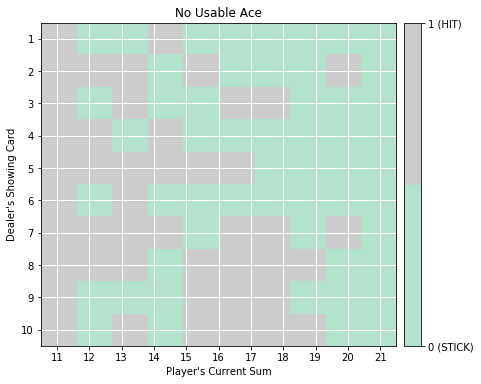

In [12]:
#%%
def get_figure(usable_ace, ax):
    x_range = np.arange(11, 22)
    y_range = np.arange(10, 0, -1)
    x = np.linspace(11,2,10) #dealer showing card
    y = np.linspace(12,21,10) #players sum
    Z = np.empty((10,10))
    X, Y = np.meshgrid(x_range, y_range)
    for i in range(len(y)):
        for j in range(len(x)):
            if bj.action_player[int(y[i]),int(x[j]),0] == 'hit':
                a = 1
            else:
                a = 0
            Z[j,i] = a
    surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
    plt.xticks(x_range)
    plt.yticks(y_range)
    plt.gca().invert_yaxis()
    ax.set_xlabel('Player\'s Current Sum')
    ax.set_ylabel('Dealer\'s Showing Card')
    ax.grid(color='w', linestyle='-', linewidth=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
    cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
        
fig = plt.figure(figsize=(15, 15))
#ax = fig.add_subplot(121)
#ax.set_title('Usable Ace')
#get_figure(True, ax)
ax = fig.add_subplot(122)
ax.set_title('No Usable Ace')
get_figure(False, ax)
plt.show()                   

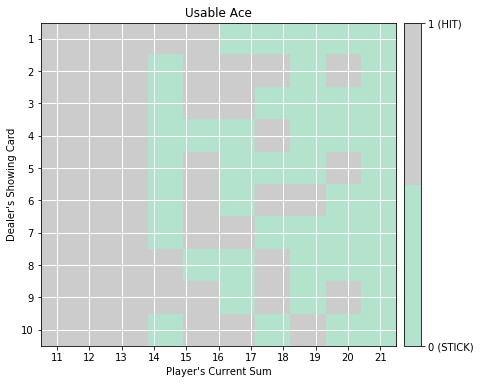

In [13]:
#%%
def get_figure(usable_ace, ax):
    x_range = np.arange(11, 22)
    y_range = np.arange(10, 0, -1)
    x = np.linspace(11,2,10) #dealer showing card
    y = np.linspace(12,21,10) #players sum
    Z = np.empty((10,10))
    X, Y = np.meshgrid(x_range, y_range)
    for i in range(len(y)):
        for j in range(len(x)):
            if bj.action_player[int(y[i]),int(x[j]),1] == 'hit':
                a = 1
            else:
                a = 0
            Z[j,i] = a
    surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
    plt.xticks(x_range)
    plt.yticks(y_range)
    plt.gca().invert_yaxis()
    ax.set_xlabel('Player\'s Current Sum')
    ax.set_ylabel('Dealer\'s Showing Card')
    ax.grid(color='w', linestyle='-', linewidth=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
    cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
        
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(121)
ax.set_title('Usable Ace')
get_figure(True, ax)

plt.show()                   

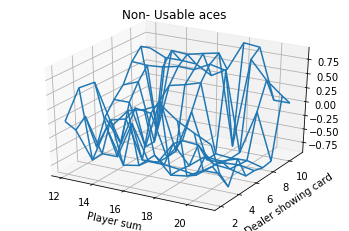

In [15]:
#%%plotting  non-usable aces
x = (itertools.product((np.arange(12,22)),\
                                             (np.arange(2,12)),\
                                             (0,1),repeat = 1))
x = np.linspace(12,21,10)
y = np.linspace(2,11,10)
X, Y = np.meshgrid(x, y)

# No usable ace
Z = np.empty((10,10))

for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j] = bj.state_value[int(x[i]),int(y[j]),0]
        
fig = plt.figure()
ax = fig.gca(projection = '3d')

wiref = ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)
plt.ylabel('Dealer showing card')
plt.xlabel('Player sum') 
plt.title('Non- Usable aces')
 
plt.show()

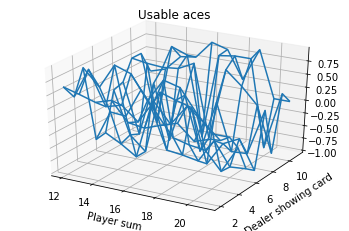

In [16]:
#%%plots for usable aces
x = (itertools.product((np.arange(12,22)),\
                                             (np.arange(2,12)),\
                                             (0,1),repeat = 1))
x = np.linspace(12,21,10)
y = np.linspace(2,11,10)
X, Y = np.meshgrid(x, y)

# No usable ace
Z = np.empty((10,10))

for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j] = bj.state_value[int(x[i]),int(y[j]),1]
        
fig = plt.figure()
ax = fig.gca(projection = '3d')

wiref = ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)
plt.ylabel('Dealer showing card')
plt.xlabel('Player sum') 
plt.title('Usable aces')
plt.show()